**Measuring Bias in clustering**

**Load the data**

In [ ]:
!pip install holisticai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.8/272.8 kB 2.1 MB/s eta 0:00:00


In [ ]:
# Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Get data
from holisticai.datasets import load_adult
df = load_adult()['frame']
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


**Data Exploration**

<Axes: >

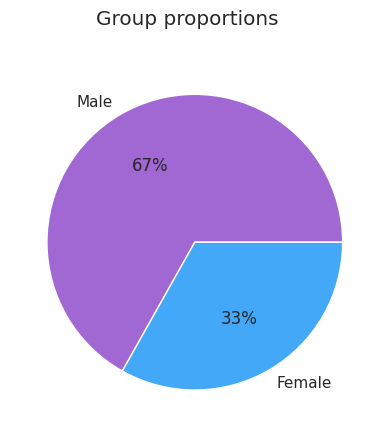

In [ ]:
# import holisticai charts
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot
# pie plot of the Sex column
p_attr = df['sex']
group_pie_plot(p_attr)

<Axes: >

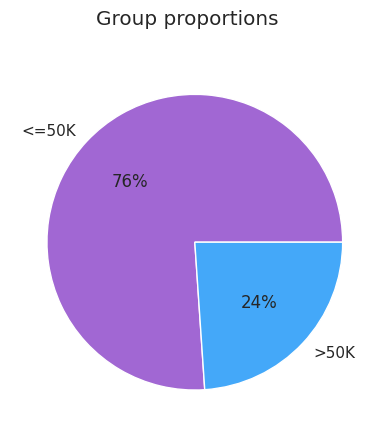

In [ ]:
# pie plot of class column
p_attr = df['class']
group_pie_plot(p_attr)

<Axes: xlabel='race', ylabel='Probability'>

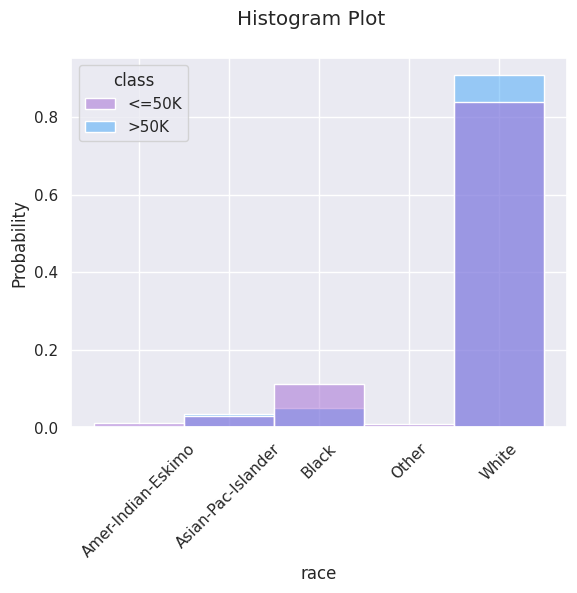

In [ ]:
# Histogram of race with class as hue
histogram_plot(df['race'], df['class'])

**Preprocess data and Train a model**

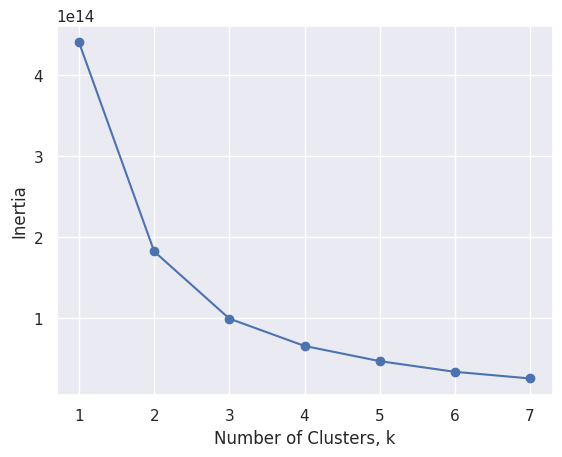

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Dataset
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1))
group = ["sex"]
group_a = df[group] == "Female"
group_b = df[group] == "Male"
data = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]
from sklearn.cluster import KMeans

ks = range(1, 8)
inertias = []
X_train, _, group_a_train, group_b_train = train_data

for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)

    # fit model to samples
    model.fit(X_train)

    # append the inertia to the list of inertias
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [ ]:
# we choose to use 4 clusters
model = KMeans(n_clusters = 4)
model.fit(X_train)

# test data
X, _, group_a, group_b = test_data

# predict
y_pred = model.predict(X)

**Measure bias**

<Axes: xlabel='Class', ylabel='Group'>

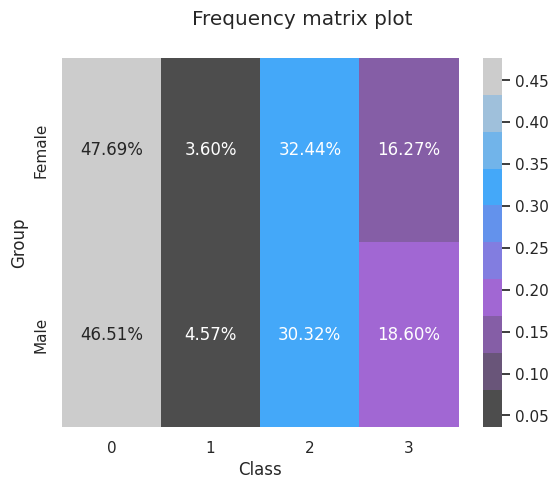

In [ ]:
# imports
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.metrics import cluster_balance
from holisticai.bias.metrics import min_cluster_ratio
# set up vectors for measuring bias [we consider sex and race]
p_attr_sex = df.iloc[X.index]['sex']
p_attr_race = df.iloc[X.index]['race']
y_pred = model.predict(X)
# probability for each gender and class
frequency_matrix_plot(p_attr_sex, y_pred, normalize='group')

<Axes: xlabel='Class', ylabel='Group'>

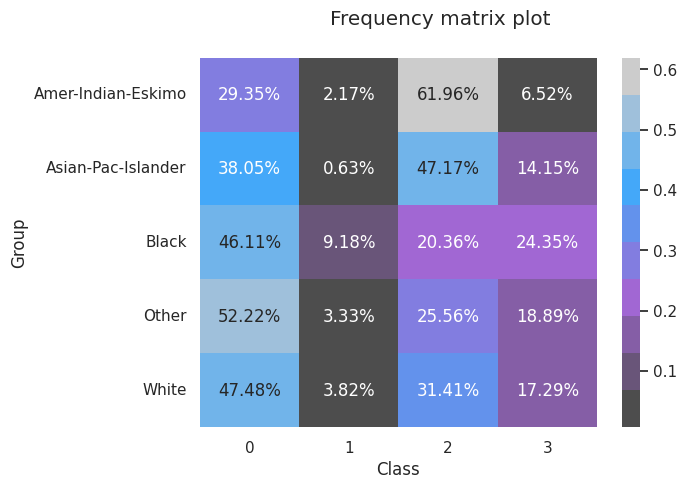

In [ ]:
# probability for each race and group
frequency_matrix_plot(p_attr_race, y_pred, normalize='group')

In terms of race representations, some clusters are quite unbalanced. So the kmeans model has learnt some implicit Race information. Depending on the application of interest, this might be a bias issue.

In [ ]:
group_a = p_attr_race=='Amer-Indian-Eskimo'
group_b = p_attr_race=='White'
cluster_balance(group_a, group_b, y_pred)

0.3659441100816622

The above metric indicates the clustering is not balanced in the sense of each group having similar representation in clusters to overall. The ideal value for this metric would be 1.

In [ ]:
group_a = p_attr_race=='Amer-Indian-Eskimo'
group_b = p_attr_race=='White'
min_cluster_ratio(group_a, group_b, y_pred)

0.004198740377886634

The above metric indicates there is a cluster where there are more white people than Amer-Indian-Eskimos. This makes sense because of the difference in representation in overall population.

In [ ]:
# import
from holisticai.bias.metrics import clustering_bias_metrics
# set up data arrays
group_a = p_attr_sex=='Female'
group_b = p_attr_sex=='Male'
y_pred = y_pred
centroids = model.cluster_centers_
data = X.to_numpy()
clustering_bias_metrics(group_a, group_b, y_pred, data = data, centroids = centroids, metric_type = 'equal_outcome')

,Value,Reference
Metric,,
Cluster Balance,0.846910,1
Minimum Cluster Ratio,0.392617,1
Cluster Distribution Total Variation,0.033055,0
Cluster Distribution KL Div,0.003522,0
Social Fairness Ratio,0.957248,1
Silhouette Difference,0.006275,0


**Bias measuring and mitigation in clustering tasks**

**1. Data tasks: loading, exploration and preprocessing**

**1.1 Imports**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')

**1.2 Data Exploration**

Dataset - "Heart Failure Clinical Records" that contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features. The objective is to predict if the patient deceased during the follow-up period.

In [ ]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


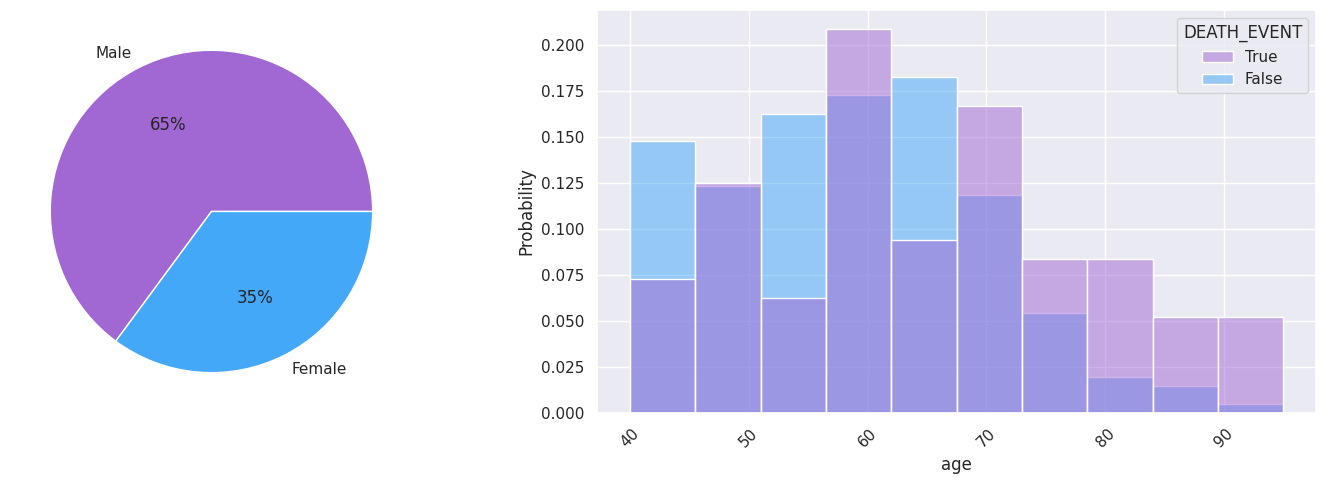

In [ ]:
from holisticai.bias.plots import group_pie_plot, histogram_plot

fig, axes = plt.subplots(nrows = 1, ncols =2, figsize=(15,5))
group_pie_plot(df['sex'].replace({1:'Male', 0:'Female'}), ax = axes[0])
histogram_plot(df['age'], df['DEATH_EVENT'].replace({1:'True', 0:'False'}), ax = axes[1])
plt.tight_layout()

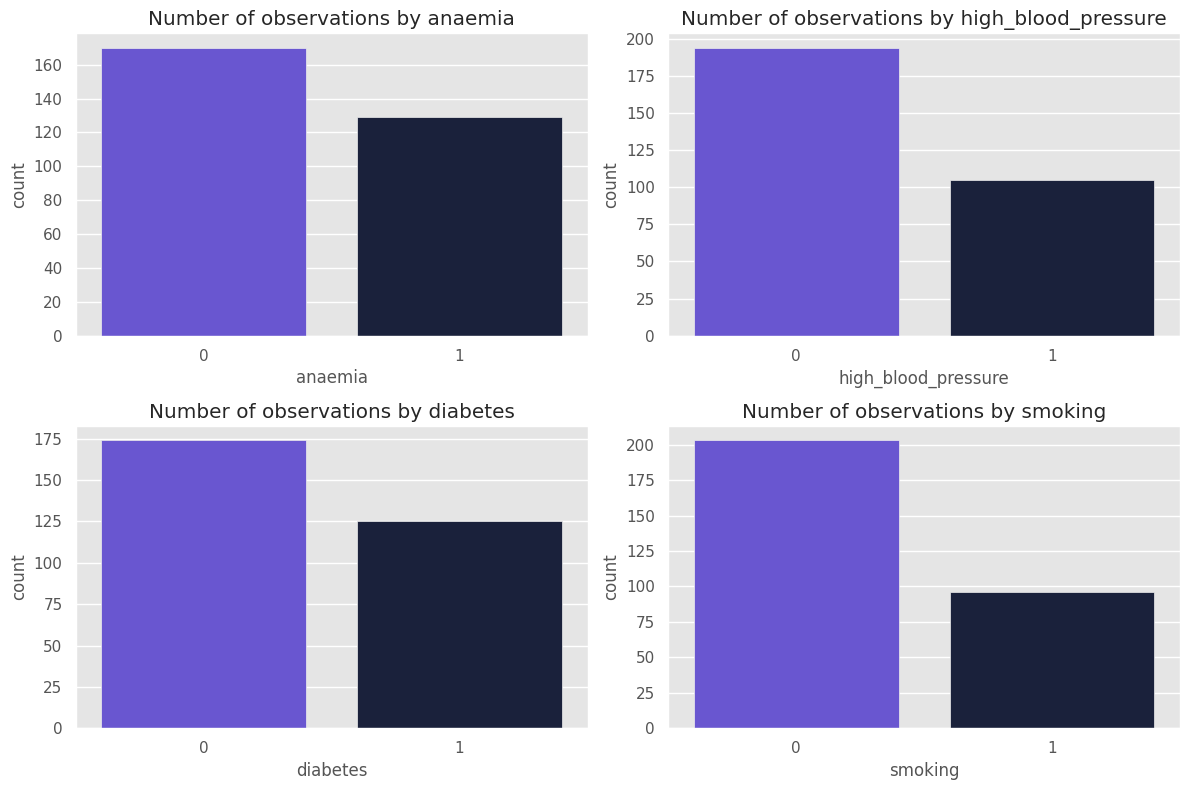

In [ ]:
colors = ["#5b42e4", "#141e41"]
plt.style.use('ggplot')
haiPallete = sns.set_palette(sns.color_palette(colors))

fig, axes = plt.subplots(ncols=2, nrows= 2, figsize=(12,8))
cols = ['anaemia', 'high_blood_pressure','diabetes','smoking']
for i, ax in zip(cols, axes.flat):
    sns.countplot(x=i, data=df, ax = ax, palette=haiPallete).set_title(f'Number of observations by {i}')
    plt.tight_layout()

**1.3 Pre-processing**

In [ ]:
def preprocessing_clustering(df, target_feature, protected_feature):
    """Performs the pre-processing step of the df."""
    # Remove NaN elements from dataframe
    df_ = df.copy()
    df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
    df_clean = df_clean.dropna()
    # Get the protected attribute vectors
    group_a = df[protected_feature] == 0
    group_b = df[protected_feature] == 1

    group_a = np.squeeze(group_a.values)
    group_b = np.squeeze(group_b.values)

    # Remove unnecessary columns

    df_clean["class"] = df_clean[target_feature]
    tmp = df_clean.drop(columns=["sex", "age", target_feature])
    df_clean = pd.concat([tmp, df_clean["class"].astype("uint8")], axis=1)

    return df_clean, group_a, group_b
df_clean, group_a, group_b = preprocessing_clustering(df, target_feature='DEATH_EVENT', protected_feature='sex')
df.shape, df_clean.shape

((299, 13), (299, 12))

In [ ]:
X = df_clean.iloc[:,:-1].values
y = df_clean.iloc[:,-1].values

X.shape, y.shape

((299, 11), (299,))

**2. Train Baseline**

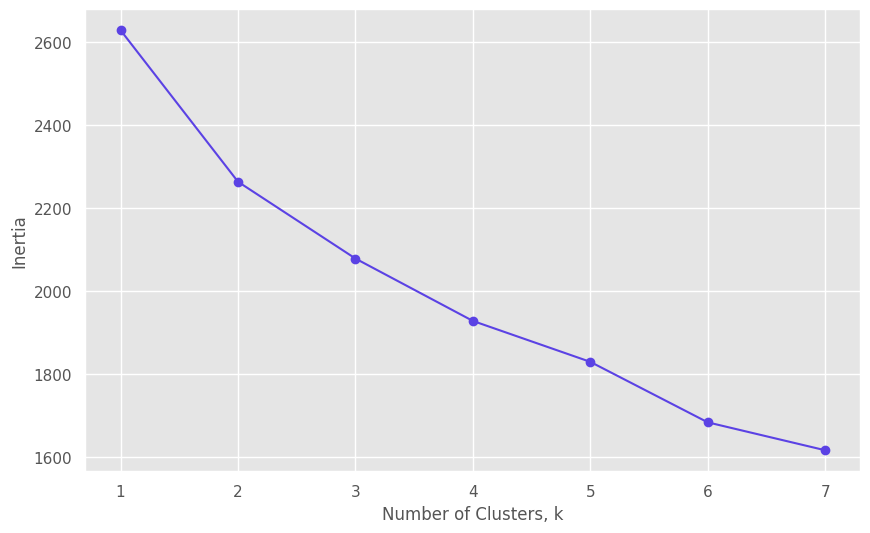

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from holisticai.pipeline import Pipeline
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
        train_test_split(X, y, group_a, group_b, test_size = 0.2, random_state = 42)

train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts
ks = range(1, 8)
inertias = []
X_train, _, group_a, group_b = train_data

scaler = StandardScaler()
X_t = scaler.fit_transform(X_train)

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(X_t)
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.figure(figsize=(10,6))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

**2.1 Bias measuring**

**clustering_bias_metrics** function allows us to select which metrics we want to calculate, if equal_outcome, equal_opportunity or both, where equal_outcome shows how disadvantaged groups are treated by the model and equal_opportunity shows if all the groups have the same opportunities.

In [ ]:
from holisticai.bias.metrics import clustering_bias_metrics

# we choose to use 3 clusters
model = KMeans(n_clusters = 3, random_state=42)
model.fit(X_t)

# predict
y_pred = model.predict(X_t)

centroids = model.cluster_centers_

df_baseline = clustering_bias_metrics(group_a, group_b, y_pred, data = X_t, centroids = centroids, metric_type = 'equal_outcome')
df_baseline

,Value,Reference
Metric,,
Cluster Balance,4.847870e-22,1
Minimum Cluster Ratio,0.000000e+00,1
Cluster Distribution Total Variation,3.766234e-01,0
Cluster Distribution KL Div,4.880311e-01,0
Social Fairness Ratio,1.055526e+00,1
Silhouette Difference,5.909859e-03,0


**Cluster Balance:** Given a clustering and protected attribute. The cluster balance is the minimum over all groups and clusters of the ratio of the representation of members of that group in that cluster to the representation overall. A value of 1 is desired. That is when all clusters have the exact same representation as the data. Lower values imply the existence of clusters where either group_a or group_b is underrepresented.

**Minimum Cluster Ratio:** Given a clustering and protected attributes. The min cluster ratio is the minimum over all clusters of the ratio of number of group_a members to the number of group_b members. A value of 1 is desired. That is when all clusters are perfectly balanced. Low values imply the existence of clusters where group_a has fewer members than group_b.

**Cluster Distribution Total Variation:** This function computes the distribution of group_a and group_b across clusters. It then outputs the total variation distance between these distributions. A value of 0 is desired. That indicates that both groups are distributed similarly amongst the clusters. The metric ranges between 0 and 1, with higher values indicating the groups are distributed in very different ways.

**Cluster Distribution KL Div: **This function computes the distribution of group_a and group_b membership across the clusters. It then returns the KL distance from the distribution of group_a to the distribution of group_b. A value of 0 is desired. That indicates that both groups are distributed similarly amongst the clusters. Higher values indicate the distributions of both groups amongst the clusters differ more.

**Social Fairness Ratio:** Given a centroid based clustering, this function compute the average distance to the nearest centroid for both groups. The metric is the ratio of the resulting distance for group_a to group_b. A value of 1 is desired. Lower values indicate the group_a is on average closer to the respective centroids. Higher values indicate that group_a is on average further from the respective centroids.

**Silhouette Difference:** We compute the difference of the mean silhouette score for both groups. The silhouette difference ranges from -1 to 1, with lower values indicating bias towards group_a and larger values indicating bias against group_b.


**3. Train Model with Mitigator**

**Pre-processing: Fairlet Clustering Preprocessing**

**Traditional Implementation**

In [ ]:
from holisticai.bias.mitigation import FairletClusteringPreprocessing

# set model
model = KMeans(n_clusters = 2, random_state=42)

X, _, group_a, group_b = train_data

# set inprocessing model
preprocessing_model = FairletClusteringPreprocessing(decomposition='Vanilla', seed=1234)

 # fit preprocessing model
preprocessing_model.fit_transform(X, group_a= group_a, group_b = group_b)

# fit model
model.fit(X)

# predict
y_pred = model.predict(X)

# set up data arrays
centroids = model.cluster_centers_

df_ = clustering_bias_metrics(group_a, group_b, y_pred, data = X, centroids = centroids, metric_type = 'equal_outcome')
df_fairlet=df_.copy()
df_fairlet

,Value,Reference
Metric,,
Cluster Balance,0.772616,1
Minimum Cluster Ratio,0.466667,1
Cluster Distribution Total Variation,0.120397,0
Cluster Distribution KL Div,0.037916,0
Social Fairness Ratio,1.165353,1
Silhouette Difference,-0.016418,0


**4. Using Pipeline**

In [ ]:
from holisticai.pipeline import Pipeline
preprocessing_model = FairletClusteringPreprocessing(decomposition='Vanilla',seed=1234)

pipeline = Pipeline(steps=[
    ('bm_preprocessing', preprocessing_model),
    ('model', model)])

# select data
X, _, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, **fit_params)

# predict
y_pred = pipeline.predict(X)

# set up data arrays
centroids = model.cluster_centers_

df = clustering_bias_metrics(group_a, group_b, y_pred, data = X, centroids = centroids, metric_type = 'equal_outcome')
df_fairlet_w_p =df.copy()
df_fairlet_w_p

,Value,Reference
Metric,,
Cluster Balance,0.995816,1
Minimum Cluster Ratio,0.550459,1
Cluster Distribution Total Variation,0.001910,0
Cluster Distribution KL Div,0.000009,0
Social Fairness Ratio,1.146100,1
Silhouette Difference,-0.020814,0


**5. Results comparison**

In [ ]:
result = pd.concat([df_baseline, df_fairlet, df_fairlet_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Cluster Balance,4.847870e-22,0.772616,0.995816,1
Minimum Cluster Ratio,0.000000e+00,0.466667,0.550459,1
Cluster Distribution Total Variation,3.766234e-01,0.120397,0.001910,0
Cluster Distribution KL Div,4.880311e-01,0.037916,0.000009,0
Social Fairness Ratio,1.055526e+00,1.165353,1.146100,1
Silhouette Difference,5.909859e-03,-0.016418,-0.020814,0


**Dataset:** Titanic Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/tested.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


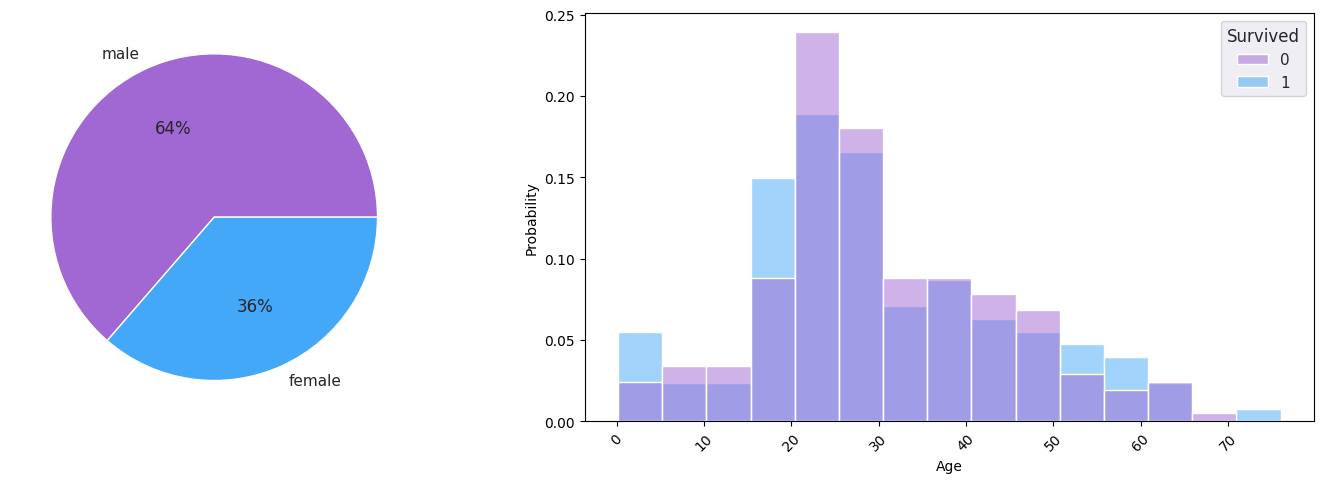

In [ ]:
from holisticai.bias.plots import group_pie_plot, histogram_plot

fig, axes = plt.subplots(nrows = 1, ncols =2, figsize=(15,5))
group_pie_plot(df['Sex'].replace({1:'male', 0:'female'}), ax = axes[0])
histogram_plot(df['Age'], df['Survived'], ax = axes[1])
plt.tight_layout()

In [ ]:
df.drop(["Name","PassengerId"],axis=1,inplace=True)
df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,34.5,0,0,330911,7.8292,NaN,Q
1,1,3,female,47.0,1,0,363272,7.0000,NaN,S
2,0,2,male,62.0,0,0,240276,9.6875,NaN,Q
3,0,3,male,27.0,0,0,315154,8.6625,NaN,S
4,1,3,female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
df.isnull().sum(), df.shape

(Survived      0
 Pclass        0
 Sex           0
 Age          86
 SibSp         0
 Parch         0
 Ticket        0
 Fare          1
 Cabin       327
 Embarked      0
 dtype: int64,
 (418, 10))

In [ ]:
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df['Ticket']= label_encoder.fit_transform(df['Ticket'])
df['Cabin']= label_encoder.fit_transform(df['Cabin'])

In [ ]:
df['Embarked'].unique()

array(['Q', 'S', 'C'], dtype=object)

In [ ]:
df["Embarked"].replace({'Q': 1, 'S': 2, 'C':33},inplace=True)

In [ ]:
#Finding the mean of the column having NaN
mean_value=df['Age'].mean()
mean_value2=df['Fare'].mean()
# Replace NaNs in column S2 with the
# mean of values in the same column
df['Age'].fillna(value=mean_value, inplace=True)
df['Fare'].fillna(value=mean_value2, inplace=True)

df['Cabin'] = df['Cabin'].fillna(df['Cabin'].mode()[0])

In [ ]:
df.isnull().sum(), df.shape

(Survived    0
 Pclass      0
 Sex         0
 Age         0
 SibSp       0
 Parch       0
 Ticket      0
 Fare        0
 Cabin       0
 Embarked    0
 dtype: int64,
 (418, 10))

In [ ]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,34.5,0,0,152,7.8292,76,1
1,1,3,female,47.0,1,0,221,7.0000,76,2
2,0,2,male,62.0,0,0,73,9.6875,76,1
3,0,3,male,27.0,0,0,147,8.6625,76,2
4,1,3,female,22.0,1,1,138,12.2875,76,2


In [ ]:
def preprocessing_clustering(df, target_feature, protected_feature):
    """Performs the pre-processing step of the df."""
    # Remove NaN elements from dataframe
    df_ = df.copy()
    df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
    df_clean = df_clean.dropna()
    # Get the protected attribute vectors
    group_a = df[protected_feature] == "female"
    group_b = df[protected_feature] == "male"

    group_a = np.squeeze(group_a.values)
    group_b = np.squeeze(group_b.values)

    # Remove unnecessary columns

    df_clean["class"] = df_clean[target_feature]
    tmp = df_clean.drop(columns=["Sex",target_feature])
    df_clean = pd.concat([tmp, df_clean["Survived"].astype("uint8")], axis=1)

    return df_clean, group_a, group_b
df_clean, group_a, group_b = preprocessing_clustering(df, target_feature='Survived', protected_feature='Sex')
df.shape, df_clean.shape

((418, 10), (418, 10))

In [ ]:
X = df_clean.iloc[:,:-1].values
y = df_clean.iloc[:,-1].values

X.shape, y.shape

((418, 9), (418,))

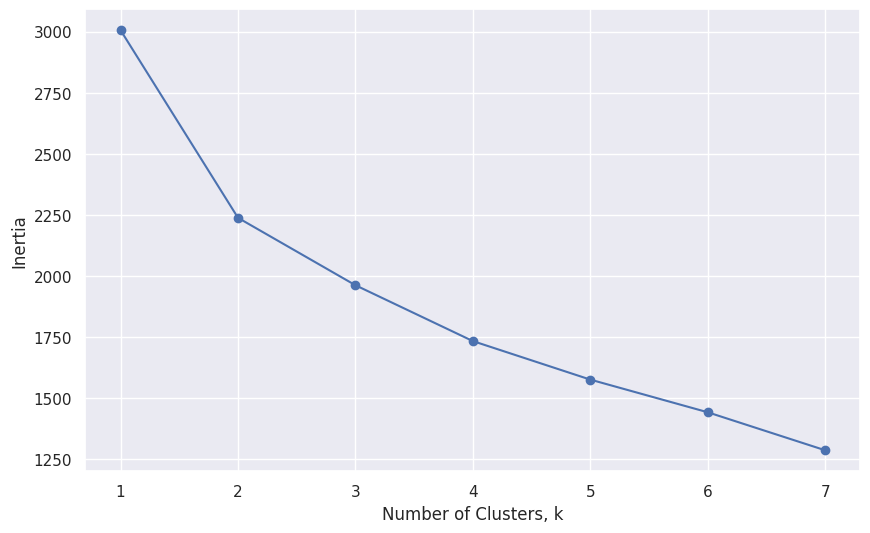

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from holisticai.pipeline import Pipeline
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
        train_test_split(X, y, group_a, group_b, test_size = 0.2, random_state = 42)

train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts
ks = range(1, 8)
inertias = []
X_train, _, group_a, group_b = train_data

scaler = StandardScaler()
X_t = scaler.fit_transform(X_train)

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(X_t)
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.figure(figsize=(10,6))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [ ]:
from holisticai.bias.metrics import clustering_bias_metrics

# we choose to use 3 clusters
model = KMeans(n_clusters = 3, random_state=42)
model.fit(X_t)

# predict
y_pred = model.predict(X_t)

centroids = model.cluster_centers_

df_baseline = clustering_bias_metrics(group_a, group_b, y_pred, data = X_t, centroids = centroids, metric_type = 'equal_outcome')
df_baseline

,Value,Reference
Metric,,
Cluster Balance,1.626729e-22,1
Minimum Cluster Ratio,0.000000e+00,1
Cluster Distribution Total Variation,8.055556e-01,0
Cluster Distribution KL Div,1.985807e+00,0
Social Fairness Ratio,1.201409e+00,1
Silhouette Difference,-8.928316e-02,0


**Pre-processing: Fairlet Clustering Preprocessing**

In [ ]:
from holisticai.bias.mitigation import FairletClusteringPreprocessing

# set model
model = KMeans(n_clusters = 2, random_state=42)

X, _, group_a, group_b = train_data

# set inprocessing model
preprocessing_model = FairletClusteringPreprocessing(decomposition='Vanilla', seed=1234)

 # fit preprocessing model
preprocessing_model.fit_transform(X, group_a= group_a, group_b = group_b)

# fit model
model.fit(X)

# predict
y_pred = model.predict(X)

# set up data arrays
centroids = model.cluster_centers_

df_ = clustering_bias_metrics(group_a, group_b, y_pred, data = X, centroids = centroids, metric_type = 'equal_outcome')
df_fairlet=df_.copy()
df_fairlet

,Value,Reference
Metric,,
Cluster Balance,0.892039,1
Minimum Cluster Ratio,0.460177,1
Cluster Distribution Total Variation,0.082470,0
Cluster Distribution KL Div,0.013624,0
Social Fairness Ratio,1.184674,1
Silhouette Difference,0.003940,0


In [ ]:
from holisticai.pipeline import Pipeline
preprocessing_model = FairletClusteringPreprocessing(decomposition='Vanilla',seed=1234)

pipeline = Pipeline(steps=[
    ('bm_preprocessing', preprocessing_model),
    ('model', model)])

# select data
X, _, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, **fit_params)

# predict
y_pred = pipeline.predict(X)

# set up data arrays
centroids = model.cluster_centers_

df = clustering_bias_metrics(group_a, group_b, y_pred, data = X, centroids = centroids, metric_type = 'equal_outcome')
df_fairlet_w_p =df.copy()
df_fairlet_w_p

,Value,Reference
Metric,,
Cluster Balance,0.943503,1
Minimum Cluster Ratio,0.500000,1
Cluster Distribution Total Variation,0.040019,0
Cluster Distribution KL Div,0.003226,0
Social Fairness Ratio,1.308528,1
Silhouette Difference,-0.041255,0


In [ ]:
result = pd.concat([df_baseline, df_fairlet, df_fairlet_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Cluster Balance,1.626729e-22,0.892039,0.943503,1
Minimum Cluster Ratio,0.000000e+00,0.460177,0.500000,1
Cluster Distribution Total Variation,8.055556e-01,0.082470,0.040019,0
Cluster Distribution KL Div,1.985807e+00,0.013624,0.003226,0
Social Fairness Ratio,1.201409e+00,1.184674,1.308528,1
Silhouette Difference,-8.928316e-02,0.003940,-0.041255,0
